In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
yf_data = yf.download('F', start="1800-01-01")
yf_data.reset_index(inplace=True)
yf_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,F,F,F,F,F,F
0,1972-06-01,0.226079,2.153220,2.173495,2.149165,0.000000,1091238
1,1972-06-02,0.225653,2.149165,2.173495,2.141055,2.153220,1174468
2,1972-06-05,0.225653,2.149165,2.169440,2.141055,2.149165,5209582
3,1972-06-06,0.223099,2.124835,2.157275,2.116725,2.149165,1424158
4,1972-06-07,0.221821,2.112670,2.137000,2.112670,2.124835,675088


In [3]:
# Daily returns calculations 
data = yf_data[["Date", "Adj Close"]]
data.set_index("Date", inplace=True)
data = data.rename(columns={"Adj Close": "Ford stock price"})
data["Daily returns"] = data["Ford stock price"].pct_change()*100
data = data.loc[data["Daily returns"] != 0]

# Volatility calculations 
rolling_window = 20
data["Rolling Mean"] = data["Daily returns"].rolling(window=rolling_window).mean()
data["Rolling Variance"] = data["Daily returns"].rolling(window=rolling_window).apply(
    lambda x: ((x - x.mean()) ** 2).sum() / (len(x) - 1), raw=True
)
data["Volatility"] = data["Rolling Variance"] ** 0.5
data.drop(columns=["Rolling Mean", "Rolling Variance"], inplace=True)

# Drop NA rows
data.dropna(axis=0, how="any", inplace=True)

data

Price,Ford stock price,Daily returns,Volatility
Ticker,F,,
Date,,,
1972-07-03,0.216712,-0.391358,0.665873
1972-07-05,0.215435,-0.589405,0.671228
1972-07-06,0.217989,1.185730,0.706325
1972-07-07,0.217138,-0.390594,0.701254
1972-07-10,0.214583,-1.176444,0.727079
...,...,...,...
2024-11-21,10.800000,0.652383,2.786684
2024-11-22,11.180000,3.518520,2.875956


Text(0, 0.5, 'Ford stock price')

<Figure size 1200x600 with 0 Axes>

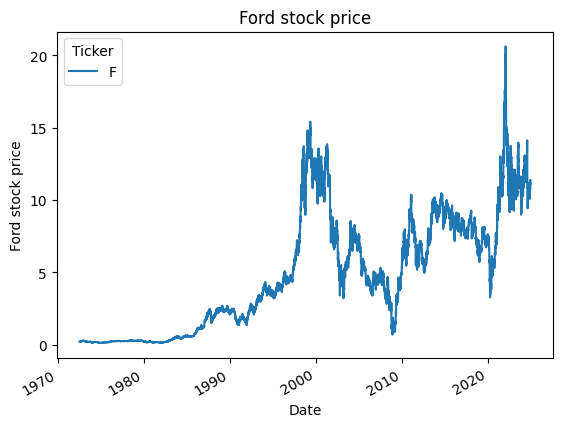

In [4]:
plt.figure(figsize=(12, 6))
data.plot(y='Ford stock price', title='Ford stock price')
plt.xlabel('Date')
plt.ylabel('Ford stock price')

In [5]:
print(f"Mean daily return is {round(data['Daily returns'].mean(), 5)}%")
print(f"Mean volatility over stock returns is {round(data['Volatility'].mean(), 5)}")

print(f"\nAnnualized mean daily return is {round(data['Daily returns'].mean()*252, 5)}%")
print(f"Annualized mean volatility over stock returns is {round(data['Volatility'].mean()*(252**0.5), 5)}")

Mean daily return is 0.05816%
Mean volatility over stock returns is 2.05099

Annualized mean daily return is 14.65635%
Annualized mean volatility over stock returns is 32.55839


TASK 2 -> GBM and Heston Models

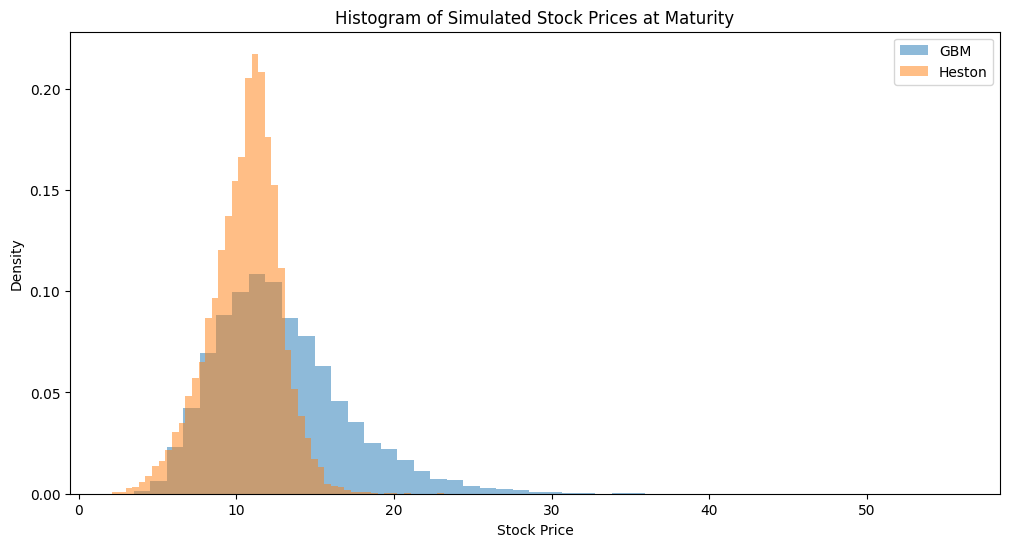

In [6]:
# Parameters
S0 = data["Ford stock price"].iloc[-1] # Initial stock price
S0 = float(S0.iloc[0])
alpha = (data['Daily returns'].mean()*252)/100  # Mean annualized return (drift)
sigma = data['Volatility'].mean()*(252**0.5)/100  # Annualized volatility
dt = 1/252  # Time step (1 trading day)
T = 1  # Total time (1 year)
N = int(T / dt)  # Number of time steps (252 days)
simulations = 10000  # Number of simulated paths

# Geometric Brownian Motion Simulation
np.random.seed(42)  # Set seed for reproducibility
random_numbers = np.random.normal(0, 1, (simulations, N))  # Generate standard normal random numbers
dW = random_numbers * np.sqrt(dt)  # Scale random numbers by sqrt(dt) for Brownian motion
W = np.cumsum(dW, axis=1)  # Compute cumulative sum along time axis for Brownian motion
t = np.arange(1, N+1) * dt  # Time points for the simulation
drift = (alpha - 0.5 * sigma**2) * t  # Compute the deterministic drift component of GBM
stock_paths_gbm = S0 * np.exp(sigma * W + drift)  # Compute GBM stock price paths

# Extract stock prices at maturity
stock_prices_gbm = stock_paths_gbm[:, -1]  # Final stock prices for each path at maturity (T)

# Heston Model Parameters
xi = 0.3  # Volatility of variance
kappa = 2.0  # Rate of mean reversion
theta = 0.04  # Long-run variance
rho = -0.7  # Correlation between stock price and variance
v0 = sigma**2  # Initial variance, squared GBM volatility

# Heston Model Simulation
v = np.full((simulations, N), v0)  # Initialize variance paths with the initial variance
random_numbers_1 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_S
random_numbers_2 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_V
dW_S = random_numbers_1 * np.sqrt(dt)  # Scale random numbers for stock price Brownian motion
dW_V = rho * random_numbers_1 * np.sqrt(dt) + np.sqrt(1 - rho**2) * random_numbers_2 * np.sqrt(dt)  
# Create correlated Brownian motion for variance using rho

# Simulate variance and enforce non-negativity
for i in range(1, N):  # Iterate over time steps
    v[:, i] = v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + xi * np.sqrt(np.maximum(v[:, i-1], 0)) * dW_V[:, i-1]  
    # Update variance based on Heston stochastic variance formula
    v[:, i] = np.maximum(v[:, i], 0)  # Ensure variance stays non-negative

# Simulate stock prices
W_S = np.cumsum(dW_S, axis=1)  # Compute cumulative Brownian motion for stock prices
integral_v = np.cumsum(v * dt, axis=1)  # Compute integral of variance over time
stock_paths_heston = S0 * np.exp(W_S * np.sqrt(v) - 0.5 * integral_v)  
# Compute Heston stock price paths using stochastic volatility

# Extract stock prices at maturity
stock_prices_heston = stock_paths_heston[:, -1]  # Final stock prices for each path at maturity (T)

# Histograms
bins = 50  # Number of bins for the histogram
plt.figure(figsize=(12, 6))  # Create a figure with specified size

plt.hist(stock_prices_gbm, bins=bins, alpha=0.5, label='GBM', density=True)  
# Plot histogram for GBM stock prices
plt.hist(stock_prices_heston, bins=bins, alpha=0.5, label='Heston', density=True)  
# Plot histogram for Heston stock prices
plt.title("Histogram of Simulated Stock Prices at Maturity")  # Add a title to the plot
plt.xlabel("Stock Price")  # Label the x-axis
plt.ylabel("Density")  # Label the y-axis
plt.legend()  # Add a legend to distinguish GBM and Heston
plt.show()  # Display the plot


### Task 4 - Pricing a Plain-Vanilla Option Under Each Stochastic Process – 20% of marks
##### We now use the risk-neutral probabilities derived in Task 3 to price a plain-vanilla option under both the Geometric Brownian motion and the stochastic volatility model. Assume that there is a European call option on your chosen stock, with a time-to-maturity of one year (you can choose a different value) and a strike price that is close to the initial stock price – you determine whether it’s slightly higher or lower. For each of the two stock price models, calculate then the mean maturity stock price per bin. Using the mean stock price at maturity, calculate the maturity payoff of the option per bin. Multiply the maturity payoff by the risk-neutral probability and sum up. Discount back to the present using the risk-free rate of return and report your results. Compare the results obtained from the different stock price models. Are they different? If so, why are they different? Explain intuitively. 
#### We’ll now try to get close to the value you derived above under the Geometric Brownian motion model by applying the Black-Scholes-Merton (BSM; 1973) closed-form solution. To that end, plug your chosen parameter values into the BSM formula. You’re likely going to be somewhat disappointed at this point: Your risk-neutral pricing result is perhaps nowhere close to the closed-form solution? This can happen. We have only simulated a limited number of standard normal random variable realizations, and we’ve only crudely approximated 𝑃̂(𝐴). If you use more realizations and sort into more bins, you’ll probably get closer. But don’t worry: The CWA is meant to improve your intuition about risk-neutral pricing. How close your risk-neutral pricing results is to the Black-Scholes Merton (1973) closed-form solution is unimportant to me – as long as you do things correctly.

In [7]:
# Parameters
S0 = 11.13                # Initial stock price
K = 12                    # Strike price, close to initial stock price
r = 0.03                  # Risk-free rate
sigma = 0.2               # Volatility for GBM
T = 1                     # Time to maturity (1 year)
paths = 1000000           # Number of simulations
bins = 5000               # Number of bins for grouping final prices
dt = 1 / 252              # Daily time step
steps = int(T / dt)       # Total number of time steps in one year


#=============================================================
# Geometric Brownian Motion (GBM)
#=============================================================
# Step 1: Simulate stock prices under GBM
simulated_prices = np.zeros((paths, steps + 1))
simulated_prices[:, 0] = S0

for t in range(1, steps + 1):
    Z = np.random.normal(0, 1, paths)  # Random shocks
    simulated_prices[:, t] = simulated_prices[:, t - 1] * np.exp(
        (r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

# Step 2: Calculate the mean maturity stock price per bin
# Stock prices at maturity
maturity_prices = simulated_prices[:, -1]   
# Create bins 
bin_edges = np.linspace(maturity_prices.min(), maturity_prices.max(), bins + 1)
# Compute mean stock price per bin
bin_means = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# New Step: Calculate empirical probabilities from bins
# Calculate empirical bin probabilities from simulated maturity prices
bin_counts, _ = np.histogram(maturity_prices, bins=bin_edges)
risk_neutral_probs = bin_counts / np.sum(bin_counts)  # Use counts to derive probabilities
# Normalize to ensure total probability = 1 (in case of rounding issues)
risk_neutral_probs /= risk_neutral_probs.sum()

# Step 3: Calculate the maturity payoff of option per bin
payoffs = np.maximum(bin_means - K, 0)

# Step 4: Multiply the maturity payoff by risk-neutral probabilities
weighted_payoffs = payoffs * risk_neutral_probs

# Step 5: Sum up the weighted payoffs
expected_payoff = np.sum(weighted_payoffs)

# Step 6: Discount back to PV
option_price = expected_payoff * np.exp(-r * T)

# Output the option price for GBM model
print(f"GBM European call option price: {option_price:.4f}")



#=============================================================
# Stochastic Volatility Model (Heston Model)
#=============================================================
# Heston Model Parameters
v0 = 0.04       # Initial variance
kappa = 2.0     # Speed of mean reversion
theta = 0.04    # Long-term variance (mean reversion level)
xi = 0.3        # Volatility of volatility
rho = -0.5      # Correlation between stock price & volatility

# Step 1: Simulate stock prices & stochastic variance
simulated_prices = np.zeros((paths, steps + 1))
simulated_prices[:, 0] = S0

simulated_volatilities = np.zeros((paths, steps + 1))
simulated_volatilities[:, 0] = v0

for t in range(1, steps + 1):
    Z1 = np.random.normal(0, 1, paths)  # Brownian motion for stock price
    Z2 = np.random.normal(0, 1, paths)  # Brownian motion for volatility

    # Correlate Z1 & Z2
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2

    # Update variance using CIR process
    simulated_volatilities[:, t] = (
        simulated_volatilities[:, t - 1]
        + kappa * (theta - simulated_volatilities[:, t-1]) * dt
        + xi * np.sqrt(simulated_volatilities[:, t-1] * dt) * Z2)
    
    # Ensure non-negative variance
    simulated_volatilities[:, t] = np.maximum(simulated_volatilities[:, t], 0)

    # Update stock price using Heston dynamics
    simulated_prices[:, t] = simulated_prices[:, t - 1] * np.exp(
        (r - 0.5 * simulated_volatilities[:, t - 1]) * dt
        + np.sqrt(simulated_volatilities[:, t - 1] * dt) * Z1)

# Step 2: Calculate the mean maturity stock price per bin
# Stock prices at maturity
maturity_prices = simulated_prices[:, -1]   
# Create bins 
bin_edges = np.linspace(maturity_prices.min(), maturity_prices.max(), bins + 1)
# Compute mean stock price per bin
bin_means = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# New Step: Calculate empirical probabilities from bins
# Calculate empirical bin probabilities from simulated maturity prices
bin_counts, _ = np.histogram(maturity_prices, bins=bin_edges)
risk_neutral_probs = bin_counts / np.sum(bin_counts)  # Use counts to derive probabilities
# Normalize to ensure total probability = 1 (in case of rounding issues)
risk_neutral_probs /= risk_neutral_probs.sum()

# Step 3: Calculate the maturity payoff of option per bin
payoffs = np.maximum(bin_means - K, 0)

# Step 4: Multiply the maturity payoff by risk-neutral probabilities
weighted_payoffs = payoffs * risk_neutral_probs

# Step 5: Sum up the weighted payoffs
expected_payoff = np.sum(weighted_payoffs)

# Step 6: Discount back to PV
option_price = expected_payoff * np.exp(-r * T)

# Output the option price for Heston model
print(f"Heston European call option price: {option_price:.4f}")



#=============================================================
# Black-Scholes-Merton Model (BSM)
#=============================================================
# Calculate d1 & d2
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# CDF of standard normal for d1 & d2
N_d1 = norm.cdf(d1)  
N_d2 = norm.cdf(d2)  

# Calculate the option price using BSM formula
option_price = S0 * N_d1 - K * np.exp(-r * T) * N_d2

# Output the option price for BSM model
print(f"BS European call option price: {option_price:.4f}")

GBM European call option price: 0.6699
Heston European call option price: 0.6196
BS European call option price: 0.6725
